Model Testing

Testing an array of binary classification models on a combined dataset of:
- DDI
- Fitzpatrick

In [1]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
import os
import sys
import glob

import numpy as np
import pandas as pd
from scipy import stats
from scipy import ndimage
import skimage.io

import torch
import torch.nn as nn
import timm
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
import torchvision
from torchvision import models, transforms
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import WeightedRandomSampler
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torchvision.models import MobileNet_V2_Weights
from torchvision.models import (VGG16_Weights, ResNet50_Weights, Inception_V3_Weights,
                                inception_v3, mobilenet_v2, MobileNet_V2_Weights)
from torchvision.models import alexnet, AlexNet_Weights
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

from PIL import Image
import cv2 as cv
import copy
from tensorflow.keras import datasets, layers, models
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
df=pd.read_csv('/content/gdrive/MyDrive/Education/Masters/Final Year Project /Models Testing/combined_data_disease_descriptions.csv',index_col=0)
df.head()

,filename,skin_tone,malignant,disease,diagnostic_type,disease_description
0,000001.png,56,True,melanoma-in-situ,Diagnostic,A localized form of melanoma that remains conf...
1,000002.png,56,True,melanoma-in-situ,Diagnostic,A localized form of melanoma that remains conf...
2,000003.png,56,True,mycosis-fungoides,Diagnostic,A type of cutaneous T-cell lymphoma that prima...
3,000004.png,56,True,squamous-cell-carcinoma-in-situ,Diagnostic,An early form of skin cancer that is confined ...
4,000005.png,12,True,basal-cell-carcinoma,Diagnostic,The most common form of skin cancer that rarel...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 17219
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   filename             1000 non-null   object
 1   skin_tone            1000 non-null   int64 
 2   malignant            1000 non-null   bool  
 3   disease              1000 non-null   object
 4   diagnostic_type      1000 non-null   object
 5   disease_description  1000 non-null   object
dtypes: bool(1), int64(1), object(4)
memory usage: 47.9+ KB


In [7]:
df['filename'].count()

1000

In [8]:
df['skin_tone'].value_counts()

skin_tone
34    383
12    328
56    289
Name: count, dtype: int64

In [9]:
# Get a list of all PNG files in the folder "combined_data"
png_images = glob.glob('/content/gdrive/MyDrive/Education/Masters/Final Year Project /Models Testing/combined_data/*.png')

# Get a list of all JPG files in the folder "combined_data"
jpg_images = glob.glob('/content/gdrive/MyDrive/Education/Masters/Final Year Project /Models Testing/combined_data/*.jpg')

# Concatenate the two lists
images = png_images + jpg_images

len(images)

17243

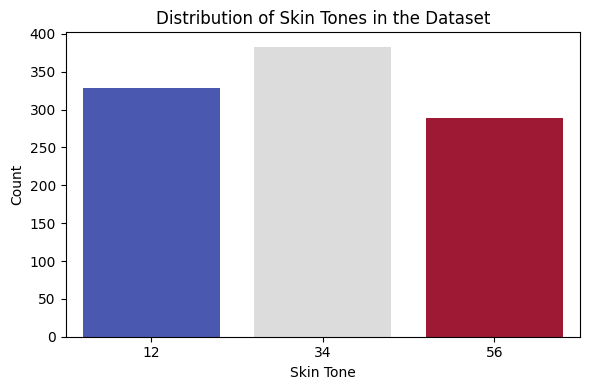

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='skin_tone', data=df, hue='skin_tone', ax=ax, palette='coolwarm', legend=False)

# Set the title and labels
ax.set_title('Distribution of Skin Tones in the Dataset')
ax.set_xlabel('Skin Tone')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

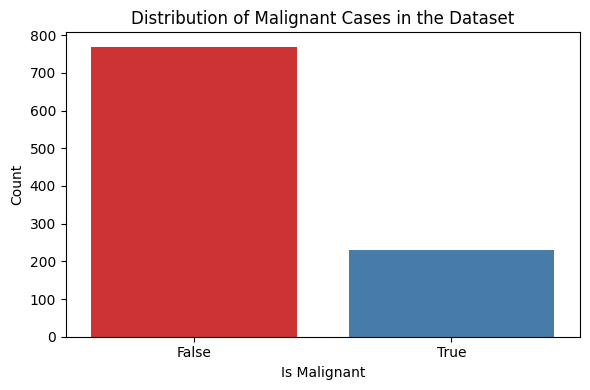

In [ ]:
#Distribution of data in 'malignant' column
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='malignant', data=df, hue='malignant', ax=ax, palette='Set1', legend=False)
ax.set_title('Distribution of Malignant Cases in the Dataset')
ax.set_xlabel('Is Malignant')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

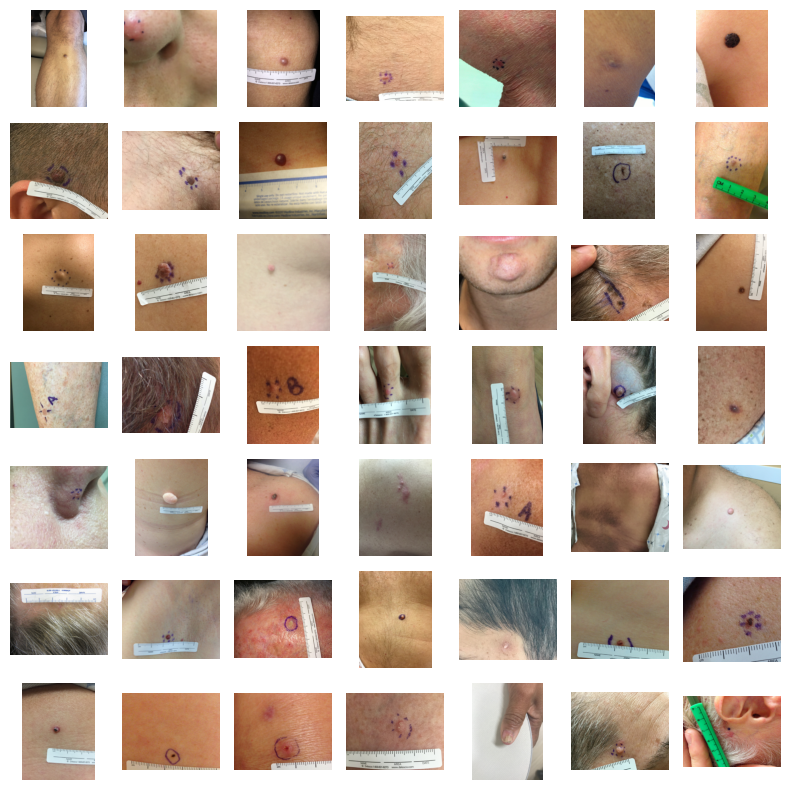

In [ ]:
plt.figure(figsize=(8, 8))
nrows, ncols = 7, 7
max_imgs = nrows * ncols  # Maximum number of images you can display

# Only loop through the first 'max_imgs' images
for i, file in enumerate(images[:max_imgs]):
    img = skimage.io.imread(file)

    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

Step 1: Define a Custom Dataset Class
This class will handle loading and transforming images on-the-fly.

In [10]:
class CustomDDIDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.ddi_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.ddi_frame['malignant'] = self.ddi_frame['malignant'].astype(int)

    def __len__(self):
        return len(self.ddi_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.ddi_frame.iloc[idx]['filename'])
        image = Image.open(img_name).convert('RGB')
        label = self.ddi_frame.iloc[idx]['malignant']
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

In [11]:
# Transformation with data augmentation for training
train_transform = T.Compose([

    T.Resize(299),  # Resize so the smallest side is 299 pixels
    T.RandomHorizontalFlip(),  # Randomly flip images horizontally
    T.RandomRotation(10),  # Randomly rotate images by up to 10 degrees
    T.RandomResizedCrop(299),  # Randomly crop and resize to 299x299
    T.ToTensor(),  # Convert image to a PyTorch tensor
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Transformation without data augmentation for validation/testing
val_transform = T.Compose([

    T.Resize(299),
    T.CenterCrop(299),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize the full dataset with transformations
full_dataset = CustomDDIDataset(csv_file='/content/gdrive/MyDrive/Education/Masters/Final Year Project /Models Testing/combined_data_disease_descriptions.csv',
                                root_dir='/content/gdrive/MyDrive/Education/Masters/Final Year Project /Models Testing/combined_data',
                                transform=train_transform)  # You might want to have a separate transform for full_dataset if necessary

# For training
train_dataset = CustomDDIDataset(csv_file='/content/gdrive/MyDrive/Education/Masters/Final Year Project /Models Testing/combined_data_disease_descriptions.csv',
                                root_dir='/content/gdrive/MyDrive/Education/Masters/Final Year Project /Models Testing/combined_data',
                                 transform=train_transform)

# For validation/testing
val_dataset = CustomDDIDataset(csv_file='/content/gdrive/MyDrive/Education/Masters/Final Year Project /Models Testing/combined_data_disease_descriptions.csv',
                                root_dir='/content/gdrive/MyDrive/Education/Masters/Final Year Project /Models Testing/combined_data',
                               transform=val_transform)

In [12]:
#Extracting the labels from the DataFrame and storing them as a numpy array
labels = df['malignant'].values
# Assuming binary classification with labels 0 and 1
class_sample_count = torch.tensor([
    (labels == 0).sum(),  # Count of class 0
    (labels == 1).sum()   # Count of class 1
])

In [13]:
#Computing class weights as the inverse of the class sample counts.
#If a class has more samples, it gets a lower weight.
#The weights are converted to float for correct division and to avoid integer division in Python.

class_weights = 1. / class_sample_count.float()

# Map each label in 'labels' to its corresponding weight
# If 'labels' is a numpy array:
samples_weights = np.array([class_weights[label].item() for label in labels])

# If 'labels' is a torch tensor:
samples_weights = torch.tensor([class_weights[label].item() for label in labels])

# Creating the WeightedRandomSampler with the computed sample weights
# This sampler will be used by a DataLoader to draw samples in a way that each class is represented equally, by sampling from the dataset according to the specified weights.
sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

<ipython-input-13-29895cd48322>:9: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  samples_weights = np.array([class_weights[label].item() for label in labels])
<ipython-input-13-29895cd48322>:12: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  samples_weights = torch.tensor([class_weights[label].item() for label in labels])


In [14]:
# Splitting the dataset into training, validation, and test sets
train_idx, val_test_idx = train_test_split(range(len(full_dataset)), test_size=0.4, random_state=42)
val_idx, test_idx = train_test_split(val_test_idx, test_size=0.5, random_state=42)

# Creating train, validation, and test subsets
train_subset = Subset(full_dataset, train_idx)
val_subset = Subset(full_dataset, val_idx)
test_subset = Subset(full_dataset, test_idx)

# Creating DataLoader instances for all subsets
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, shuffle=False) #THIS LINE WAS CHANGED
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

In [18]:
def train_model(model, criterion, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs=30, patience=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    train_losses = []
    train_accuracys = []
    val_losses = []
    val_accuracys = []

    for epoch in range(num_epochs):

        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Training phase
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_loss = running_loss / len(train_dataloader.dataset)
        train_acc = running_corrects.double() / len(train_dataloader.dataset)
        train_losses.append(train_loss)
        train_accuracys.append(train_acc)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_corrects = 0

        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_dataloader.dataset)
        val_acc = val_corrects.double() / len(val_dataloader.dataset)
        val_losses.append(val_loss)
        val_accuracys.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        # Checkpointing
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            print('Validation loss decreased, saving model...')
        else:
            epochs_no_improve += 1
            print(f'Validation loss did not decrease, epochs with no improvement: {epochs_no_improve}.')

        if epochs_no_improve == patience:
            print('Early stopping triggered.')
            break

        scheduler.step()

    print('Training complete. Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracys, val_losses, val_accuracys

In [ ]:
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    # For reproducibility of results for certain CUDA operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42  # or any other number you want
set_seed(seed)

**Models Testing**
MobileNetV2 model

In [19]:
from torchvision import models
# Initialize the MobileNetV2 model with pre-trained weights
mobilenet_v2_model = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

# Modifying the classifier for binary classification
num_ftrs = mobilenet_v2_model.classifier[1].in_features
mobilenet_v2_model.classifier[1] = nn.Linear(num_ftrs, 2)

# Define the device and move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_v2_model = mobilenet_v2_model.to(device)

# Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v2_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Call the updated train_model function with train and validation dataloaders
MobileNetV2_best_model = train_model(mobilenet_v2_model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=30, patience=5)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 225MB/s]


Epoch 1/30
Train Loss: 0.6387 Acc: 0.6160
Validation Loss: 0.4757 Acc: 0.8100
Validation loss decreased, saving model...
Epoch 2/30
Train Loss: 0.5404 Acc: 0.7200
Validation Loss: 0.5037 Acc: 0.7650
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 3/30
Train Loss: 0.4974 Acc: 0.7580
Validation Loss: 0.4280 Acc: 0.7900
Validation loss decreased, saving model...
Epoch 4/30
Train Loss: 0.4685 Acc: 0.7800
Validation Loss: 0.3869 Acc: 0.8050
Validation loss decreased, saving model...
Epoch 5/30
Train Loss: 0.4132 Acc: 0.8120
Validation Loss: 0.2747 Acc: 0.8950
Validation loss decreased, saving model...
Epoch 6/30
Train Loss: 0.3628 Acc: 0.8410
Validation Loss: 0.2742 Acc: 0.8900
Validation loss decreased, saving model...
Epoch 7/30
Train Loss: 0.3819 Acc: 0.8310
Validation Loss: 0.3059 Acc: 0.8550
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 8/30
Train Loss: 0.3041 Acc: 0.8720
Validation Loss: 0.2017 Acc: 0.9400
Validation loss decreased, savi

In [ ]:
torch.save(MobileNetV2_best_model.state_dict(), '/content/gdrive/MyDrive/Education/Masters/Final Year Project /Models Testing/MobileNetV2_model.pth')

**Xception**

In [29]:
# Create the Xception model with pre-trained weights using the updated model name
xception_model = timm.create_model('legacy_xception', pretrained=True)

# Modify the classifier for binary classification
num_ftrs = xception_model.fc.in_features
xception_model.fc = nn.Linear(num_ftrs, 2)

# Define the device and move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xception_model = xception_model.to(device)

# Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(xception_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Xception_best_model, train_losses, train_accuracys, val_losses, val_accuracys = train_model(xception_model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=15, patience=3)

Epoch 1/15
Train Loss: 0.6436 Acc: 0.6390
Validation Loss: 0.5326 Acc: 0.8050
Validation loss decreased, saving model...
Epoch 2/15
Train Loss: 0.5325 Acc: 0.7450
Validation Loss: 0.4674 Acc: 0.8300
Validation loss decreased, saving model...
Epoch 3/15
Train Loss: 0.4145 Acc: 0.8180
Validation Loss: 0.3416 Acc: 0.8900
Validation loss decreased, saving model...
Epoch 4/15
Train Loss: 0.3514 Acc: 0.8580
Validation Loss: 0.2489 Acc: 0.9050
Validation loss decreased, saving model...
Epoch 5/15
Train Loss: 0.3181 Acc: 0.8600
Validation Loss: 0.2709 Acc: 0.8950
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 6/15
Train Loss: 0.2281 Acc: 0.9220
Validation Loss: 0.2174 Acc: 0.9050
Validation loss decreased, saving model...
Epoch 7/15
Train Loss: 0.2203 Acc: 0.9140
Validation Loss: 0.2359 Acc: 0.8900
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 8/15
Train Loss: 0.2093 Acc: 0.9150
Validation Loss: 0.1882 Acc: 0.9300
Validation loss decreased, savi

In [30]:
def evaluate_model(model, dataloader, device, train_losses, val_losses, train_accuracys,  val_accuracys):
    model.eval()  # Set model to evaluation mode
    true_labels = []
    predictions = []
    pred_probs = []  # Store prediction probabilities for ROC AUC calculation

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            # Assuming the model outputs logit scores, apply softmax to get probabilities
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Get the probability of the positive class

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())
            pred_probs.extend(probs)  # Append probability of positive class

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    auc_score = roc_auc_score(true_labels, pred_probs)  # Calculate ROC AUC score
    conf_matrix = confusion_matrix(true_labels, predictions)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC Score: {auc_score:.4f}')
    print('Confusion Matrix:\n', conf_matrix)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(true_labels, pred_probs)
    plt.plot(fpr, tpr, marker='.', label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend()
    plt.show()

    # Plot training and validation losses
    plt.subplot(1, 2, 2)  # Second subplot for loss plot
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot training and validation Accuracy
    plt.subplot(1, 2, 2)  # Second subplot for loss plot
    plt.plot(train_accuracys, label='Training Accuracy')
    plt.plot(val_accuracys, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [31]:
# Converting tensors to Python lists using list comprehension
train_accuracy_list = [x.item() for x in train_accuracys]
validation_accuracy_list = [x.item() for x in val_accuracys]

Accuracy: 0.9800
Precision: 0.9608
Recall: 0.9608
F1 Score: 0.9608
ROC AUC Score: 0.9938
Confusion Matrix:
 [[147   2]
 [  2  49]]


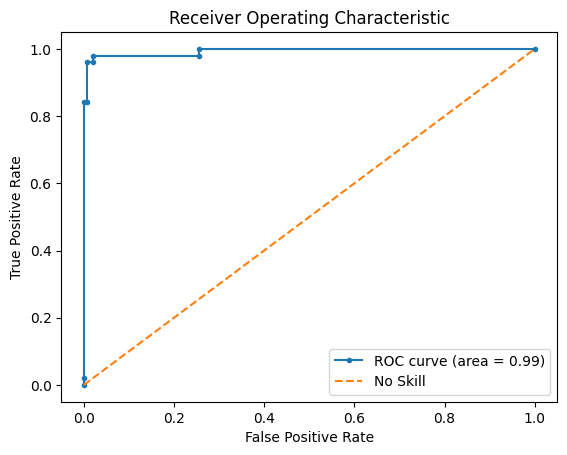

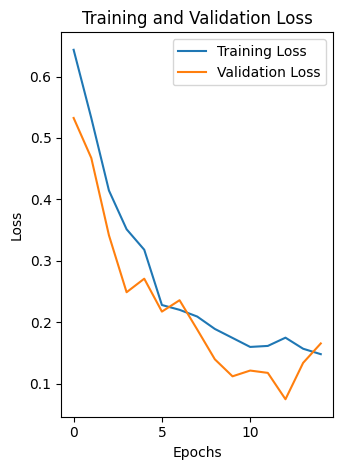

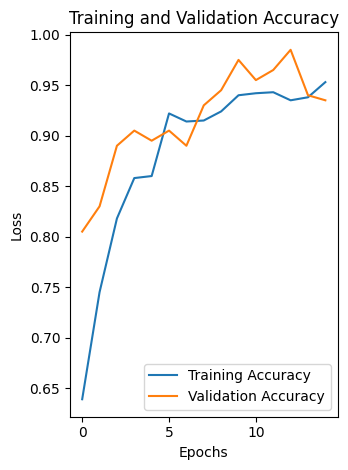

In [32]:
#evaluate_model(Xception_best_model, test_loader, device)
evaluate_model(Xception_best_model, test_loader, device, train_losses, val_losses, train_accuracy_list,  validation_accuracy_list)

In [33]:
torch.save(Xception_best_model.state_dict(), '/content/gdrive/MyDrive/Education/Masters/Final Year Project /Models Testing/Xception_model.pth')

**EfficientNet-BO (Baseline)**

In [ ]:
# Create the EfficientNet model with pre-trained weights
#efficientnet_model = timm.create_model('efficientnet_b0', pretrained=True)
efficientnet_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

# Modify the classifier for binary classification
#num_ftrs = efficientnet_model.classifier.in_features
#efficientnet_model.classifier = nn.Linear(num_ftrs, 2)
# Modify the classifier for binary classification
if isinstance(efficientnet_model.classifier, nn.Sequential):
    num_ftrs = efficientnet_model.classifier[-1].in_features
    efficientnet_model.classifier[-1] = nn.Linear(num_ftrs, 2)
else:
    num_ftrs = efficientnet_model.classifier.in_features
    efficientnet_model.classifier = nn.Linear(num_ftrs, 2)

# Define the device and move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet_model = efficientnet_model.to(device)

# Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training the model
# Assuming `train_model` is a function defined elsewhere that handles the training loop
EfficientNet_best_model, train_losses, train_accuracys, val_losses, val_accuracys = train_model(efficientnet_model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=20, patience=3)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Epoch 1/20
Train Loss: 0.6090 Acc: 0.6590
Validation Loss: 0.5539 Acc: 0.7650
Validation loss decreased, saving model...
Epoch 2/20
Train Loss: 0.5399 Acc: 0.7510
Validation Loss: 0.7896 Acc: 0.6000
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 3/20
Train Loss: 0.4971 Acc: 0.7680
Validation Loss: 0.3875 Acc: 0.8300
Validation loss decreased, saving model...
Epoch 4/20
Train Loss: 0.4495 Acc: 0.7860
Validation Loss: 0.6795 Acc: 0.7500
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 5/20
Train Loss: 0.4537 Acc: 0.7880
Validation Loss: 0.5239 Acc: 0.7950
Validation loss did not decrease, epochs with no improvement: 2.
Epoch 6/20
Train Loss: 0.4252 Acc: 0.8030
Validation Loss: 0.5504 Acc: 0.7950
Validation loss did not decrease, epochs with no improvement: 3.
Early stopping triggered.
Training complete. Best val Loss: 0.387509


In [ ]:
# Converting tensors to Python lists using list comprehension
train_accuracy_list = [x.item() for x in train_accuracys]
validation_accuracy_list = [x.item() for x in val_accuracys]

Accuracy: 0.8650
Precision: 0.7222
Recall: 0.7647
F1 Score: 0.7429
ROC AUC Score: 0.9428
Confusion Matrix:
 [[134  15]
 [ 12  39]]


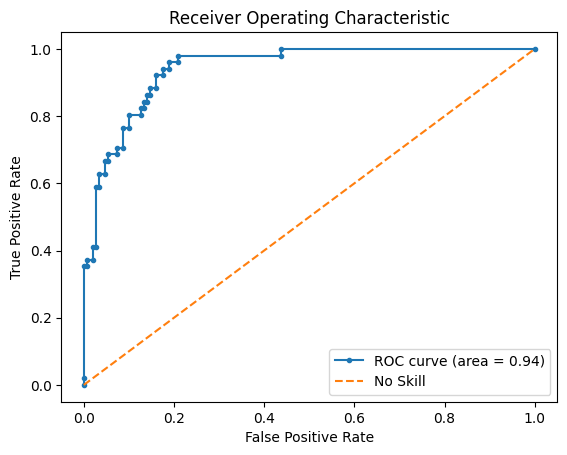

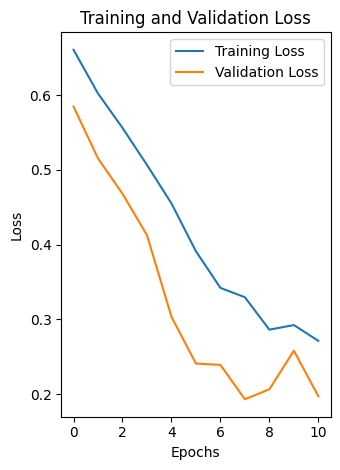

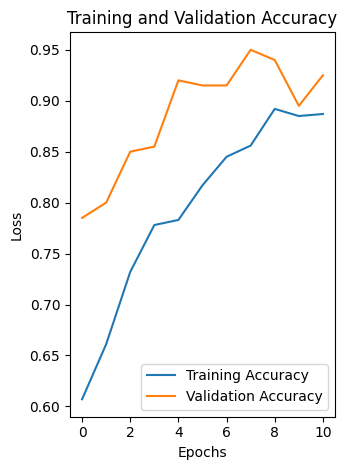

In [ ]:
evaluate_model(EfficientNet_best_model, test_loader, device, train_losses, val_losses, train_accuracy_list, validation_accuracy_list)

**EfficientNet-B4**

scaled EfficientNet

In [ ]:
# Create the EfficientNet model with pre-trained weights
#efficientnet_model = timm.create_model('efficientnet_b0', pretrained=True)
efficientnet_model_b4 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=True)

# Modify the classifier for binary classification
if isinstance(efficientnet_model_b4.classifier, nn.Sequential):
    num_ftrs = efficientnet_model_b4.classifier[-1].in_features
    efficientnet_model_b4.classifier[-1] = nn.Linear(num_ftrs, 2)
else:
    num_ftrs = efficientnet_model_b4.classifier.in_features
    efficientnet_model_b4.classifier = nn.Linear(num_ftrs, 2)

# Define the device and move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet_model_b4 = efficientnet_model_b4.to(device)

# Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model_b4.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training the model
# Assuming `train_model` is a function defined elsewhere that handles the training loop
EfficientNet_b4_best_model, train_losses, train_accuracys, val_losses, val_accuracys  = train_model(efficientnet_model_b4, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=30, patience=3)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Epoch 1/30
Train Loss: 0.6735 Acc: 0.5820
Validation Loss: 0.6644 Acc: 0.5950
Validation loss decreased, saving model...
Epoch 2/30
Train Loss: 0.6375 Acc: 0.6400
Validation Loss: 0.6090 Acc: 0.6950
Validation loss decreased, saving model...
Epoch 3/30
Train Loss: 0.5820 Acc: 0.6890
Validation Loss: 0.5368 Acc: 0.7650
Validation loss decreased, saving model...
Epoch 4/30
Train Loss: 0.5370 Acc: 0.7450
Validation Loss: 0.4416 Acc: 0.8300
Validation loss decreased, saving model...
Epoch 5/30
Train Loss: 0.4923 Acc: 0.7620
Validation Loss: 0.3529 Acc: 0.8900
Validation loss decreased, saving model...
Epoch 6/30
Train Loss: 0.3975 Acc: 0.8390
Validation Loss: 0.2683 Acc: 0.9000
Validation loss decreased, saving model...
Epoch 7/30
Train Loss: 0.3541 Acc: 0.8490
Validation Loss: 0.2613 Acc: 0.8650
Validation loss decreased, saving model...
Epoch 8/30
Train Loss: 0.3290 Acc: 0.8540
Validation Loss: 0.2555 Acc: 0.9150
Validation loss decreased, saving model...
Epoch 9/30
Train Loss: 0.3367 Ac

In [ ]:
# Converting tensors to Python lists using list comprehension
train_accuracy_list = [x.item() for x in train_accuracys]
validation_accuracy_list = [x.item() for x in val_accuracys]

Accuracy: 0.8950
Precision: 0.7500
Recall: 0.8824
F1 Score: 0.8108
ROC AUC Score: 0.9626
Confusion Matrix:
 [[134  15]
 [  6  45]]


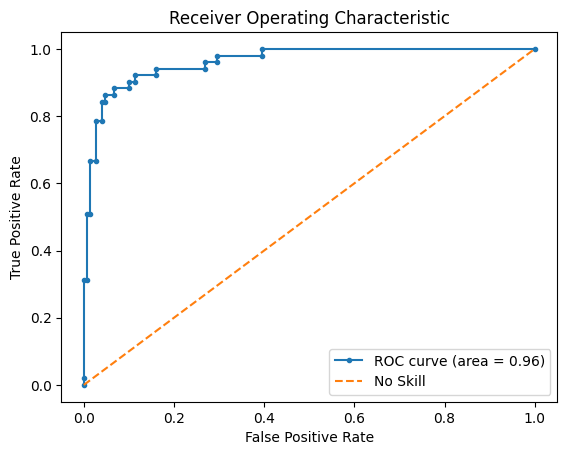

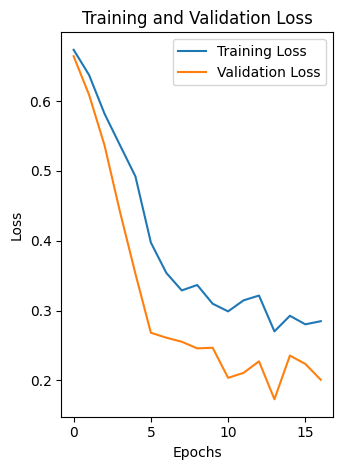

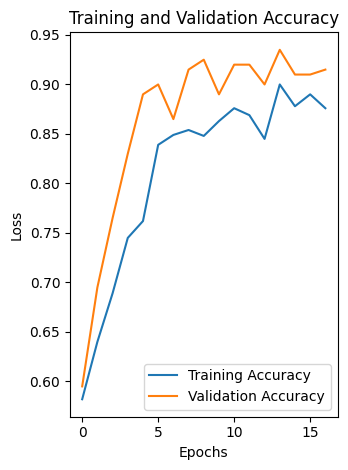

In [ ]:
#evaluate_model(Xception_best_model, test_loader, device)
evaluate_model(EfficientNet_b4_best_model, test_loader, device, train_losses, val_losses, train_accuracy_list, validation_accuracy_list)

**EfficientNet Widese B0**

model with Squeeze-and-Excitation layers wider than baseline EfficientNet model

In [ ]:
# Create the EfficientNet model with pre-trained weights
#efficientnet_model = timm.create_model('efficientnet_b0', pretrained=True)
efficientnet_widese_b0_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_widese_b0', pretrained=True)

# Modify the classifier for binary classification
if isinstance(efficientnet_widese_b0_model.classifier, nn.Sequential):
    num_ftrs = efficientnet_widese_b0_model.classifier[-1].in_features
    efficientnet_widese_b0_model.classifier[-1] = nn.Linear(num_ftrs, 2)
else:
    num_ftrs = efficientnet_widese_b0_model.classifier.in_features
    efficientnet_widese_b0_model.classifier = nn.Linear(num_ftrs, 2)

# Define the device and move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet_widese_b0_model = efficientnet_widese_b0_model.to(device)

# Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_widese_b0_model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training the model
# Assuming `train_model` is a function defined elsewhere that handles the training loop
EfficientNet_widese_b0_model_best_model, train_losses, train_accuracys, val_losses, val_accuracys  = train_model(efficientnet_widese_b0_model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=15, patience=3)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Epoch 1/15
Train Loss: 0.6613 Acc: 0.6060
Validation Loss: 0.6096 Acc: 0.7800
Validation loss decreased, saving model...
Epoch 2/15
Train Loss: 0.6001 Acc: 0.6880
Validation Loss: 0.5709 Acc: 0.7600
Validation loss decreased, saving model...
Epoch 3/15
Train Loss: 0.5251 Acc: 0.7440
Validation Loss: 0.4516 Acc: 0.8000
Validation loss decreased, saving model...
Epoch 4/15
Train Loss: 0.4688 Acc: 0.7850
Validation Loss: 0.4124 Acc: 0.8350
Validation loss decreased, saving model...
Epoch 5/15
Train Loss: 0.4318 Acc: 0.8160
Validation Loss: 0.3138 Acc: 0.8900
Validation loss decreased, saving model...
Epoch 6/15
Train Loss: 0.3665 Acc: 0.8470
Validation Loss: 0.2691 Acc: 0.8950
Validation loss decreased, saving model...
Epoch 7/15
Train Loss: 0.3024 Acc: 0.8730
Validation Loss: 0.2716 Acc: 0.8900
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 8/15
Train Loss: 0.2909 Acc: 0.8750
Validation Loss: 0.2648 Acc: 0.8850
Validation loss decreased, saving model...
Epoch 9/15

In [ ]:
# Converting tensors to Python lists using list comprehension
train_accuracy_list = [x.item() for x in train_accuracys]
validation_accuracy_list = [x.item() for x in val_accuracys]

Accuracy: 0.8850
Precision: 0.7414
Recall: 0.8431
F1 Score: 0.7890
ROC AUC Score: 0.9539
Confusion Matrix:
 [[134  15]
 [  8  43]]


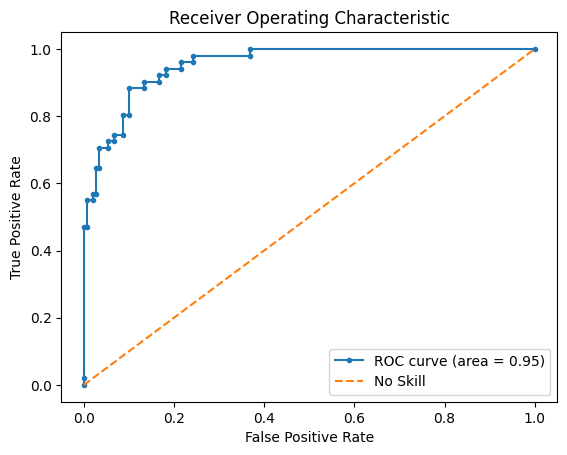

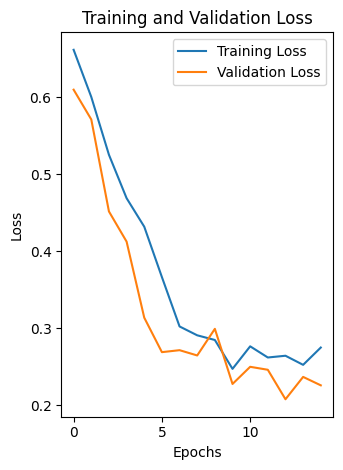

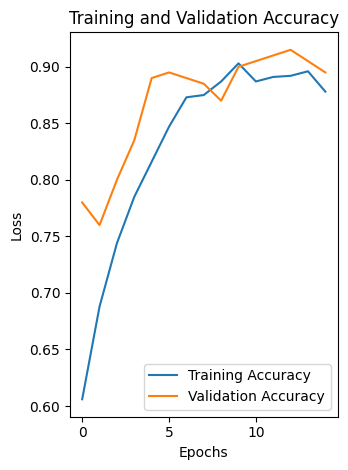

In [ ]:
#evaluate_model(Xception_best_model, test_loader, device)
evaluate_model(EfficientNet_widese_b0_model_best_model, test_loader, device, train_losses, val_losses, train_accuracy_list, validation_accuracy_list)

**EfficientNet Widese B4**

model with Squeeze-and-Excitation layers wider than scaled EfficientNet model

In [22]:
# Create the EfficientNet model with pre-trained weights
#efficientnet_model = timm.create_model('efficientnet_b0', pretrained=True)
efficientnet_widese_b4_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_widese_b4', pretrained=True)

# Modify the classifier for binary classification
if isinstance(efficientnet_widese_b4_model.classifier, nn.Sequential):
    num_ftrs = efficientnet_widese_b4_model.classifier[-1].in_features
    efficientnet_widese_b4_model.classifier[-1] = nn.Linear(num_ftrs, 2)
else:
    num_ftrs = efficientnet_widese_b4_model.classifier.in_features
    efficientnet_widese_b4_model.classifier = nn.Linear(num_ftrs, 2)

# Define the device and move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet_widese_b4_model = efficientnet_widese_b4_model.to(device)

# Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_widese_b4_model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training the model
# Assuming `train_model` is a function defined elsewhere that handles the training loop
EfficientNet_widese_b4_model_best_model, train_losses, train_accuracys, val_losses, val_accuracys  = train_model(efficientnet_widese_b4_model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25, patience=3)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

Epoch 1/25
Train Loss: 0.6651 Acc: 0.6030
Validation Loss: 0.5898 Acc: 0.7400
Validation loss decreased, saving model...
Epoch 2/25
Train Loss: 0.5997 Acc: 0.7040
Validation Loss: 0.5897 Acc: 0.7300
Validation loss decreased, saving model...
Epoch 3/25
Train Loss: 0.5558 Acc: 0.7210
Validation Loss: 0.4570 Acc: 0.8550
Validation loss decreased, saving model...
Epoch 4/25
Train Loss: 0.4825 Acc: 0.7790
Validation Loss: 0.3883 Acc: 0.8700
Validation loss decreased, saving model...
Epoch 5/25
Train Loss: 0.4598 Acc: 0.7910
Validation Loss: 0.3641 Acc: 0.8400
Validation loss decreased, saving model...
Epoch 6/25
Train Loss: 0.3790 Acc: 0.8510
Validation Loss: 0.2090 Acc: 0.9300
Validation loss decreased, saving model...
Epoch 7/25
Train Loss: 0.3411 Acc: 0.8510
Validation Loss: 0.2247 Acc: 0.9150
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 8/25
Train Loss: 0.3266 Acc: 0.8580
Validation Loss: 0.2452 Acc: 0.9150
Validation loss did not decrease, epochs with no impr

In [23]:
# Converting tensors to Python lists using list comprehension
train_accuracy_list = [x.item() for x in train_accuracys]
validation_accuracy_list = [x.item() for x in val_accuracys]

Accuracy: 0.8600
Precision: 0.7674
Recall: 0.6471
F1 Score: 0.7021
ROC AUC Score: 0.9181
Confusion Matrix:
 [[139  10]
 [ 18  33]]


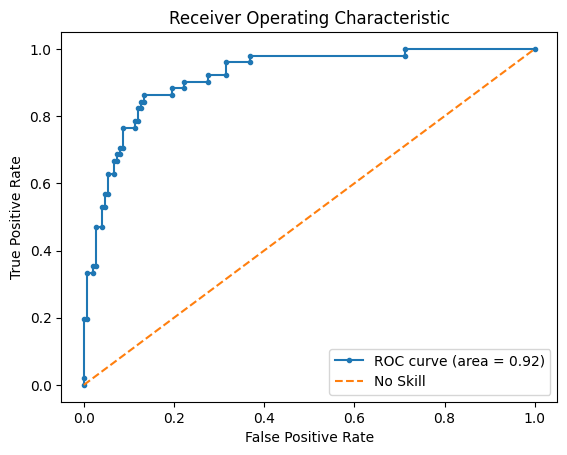

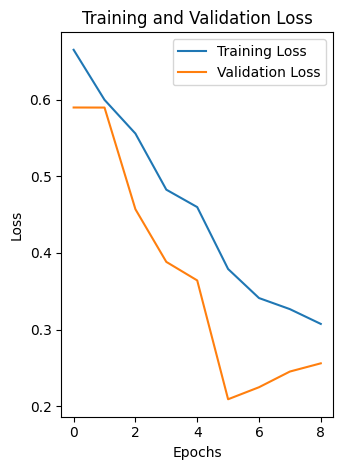

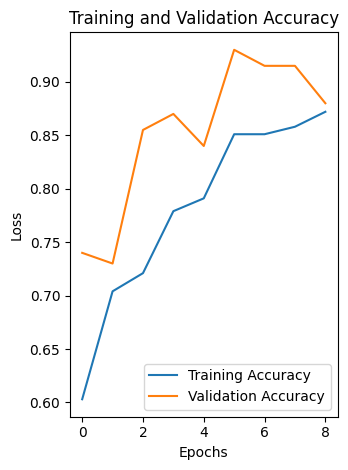

In [24]:
#evaluate_model(Xception_best_model, test_loader, device)
evaluate_model(EfficientNet_widese_b4_model_best_model, test_loader, device, train_losses, val_losses, train_accuracy_list, validation_accuracy_list)